# Задача на разработку

Ваше задание написать ETL пайплайн для выгрузки Валют и объединения с данными для отчета.

* Создайте БД sqlite
* Скачайте валюту за конкретный день и положите в БД sqlite
* Скачайте данные за конкретный день и положите в БД sqlite
* Объедините данные в sqlite по валюте и положите в отдельную таблицу или витрину (View)
* Отправьте полученный отчет за этот день на почту (создайте свою по примеру ранее, лучше на яндексе с ним попроще)

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import sqlalchemy as db

In [2]:
# Создайте базу данных sqlite, можно использовать sqlalchemy или pandas, или любой другой инструмент
# Задайте почту на которую будет отправлен отчет (создайте свою по примеру ранее, или воспользуйтесь готовой)

ENGINE = db.create_engine('sqlite:///data.sqlite')
EMAIL = 'stepikairflowcourse@yandex.ru'

In [3]:
# Напишите функцию которая принимает на вход дату
# и выгружает курс валюты EUR к USD за этот день
# Функция должна вернуть список словарей или можно использовать можно использоват pandas.read_csv()

# Для этого воспользуйтесь https://exchangerate.host/#/
# и методом Timeseries Endpoint! Строго им. Где start_date = end_date = date
# Используйте параметры start_date, end_date, base=EUR, symbols=USD, format=csv


def extract_currency(date):
    url = f'https://api.exchangerate.host/timeseries?start_date={date}&end_date={date}&format=csv'
    return pd.read_csv(url)[['date', 'code', 'rate', 'base']]

In [4]:
# Напишите функцию которая скачивает данные с гитхаба
# Функция принимает на вход дату
# Функция должна вернуть список словарей или можно использовать можно использоват pandas.read_csv()

# ссылка на гитхаб с файлами - https://github.com/dm-novikov/stepik_airflow_course/tree/main/data_new


def extract_data(date):
    url = f'https://raw.githubusercontent.com/dm-novikov/stepik_airflow_course/main/data_new/{date}.csv'
    return pd.read_csv(url)

In [5]:
# Напишите функцию которая принимает на вход список словарей
# и загружает в табличку в sqlite, можно использоват pandas.to_sql()


def insert_to_db(data, table_name, conn):
    data.to_sql(table_name, conn, if_exists='replace')

In [6]:
# Напишите функцию которая выполнит SQL запрос к базу данных
# Здесь удобно использовать sqlalchemy или https://pythonru.com/biblioteki/vvedenie-v-sqlite-python
# Если выполняется select ... то функция должна возвращать результат (не None)
# Если используется внутренняя операция например truncate table, insert into select ... то возвращает None
# data = sql_query(sql="select * from table") -> [(1, 2, 3), (4, 5, 6) ...]
# sql_query("truncate table") -> None


def select(sql, engine):
    with engine.connect() as con:
        return pd.read_sql(sql, con)
    
def execute(sql, engine):
    with engine.connect() as con:
        return con.execute(sql)

In [7]:
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import smtplib

HOST = "smtp.yandex.ru"
TO = "stepikairflowcourse@yandex.ru"
FROM = "stepikairflowcourse@yandex.ru"


def html_pretty(df):
    """ Pretty html dataframe
    """
    return """\
    <html>
      <head></head>
      <body>
        {0}
      </body>
    </html>
    """.format(df.to_html())


def _send_email(data, cred, host, port, to, From):
    """ Send DF to email
    """

    msg = MIMEMultipart()
    part = MIMEText(html_pretty(data), 'html')
    msg.attach(part)

    server = smtplib.SMTP(host, port)
    server.starttls()
    server.login(cred[0], cred[1])
    server.sendmail(From, to, msg.as_string())
    server.quit()

In [8]:
# Напишите функцию которая отправит полученный отчет на почту
# Для этого можете воспользоваться кодом который был написан ранее (на уроке)
# обернув его в вашу функцию


def send_report(data, email):
    _send_email(data=data,
                cred=("stepikairflowcourse", "123456aA-"),
                host=HOST,
                port=587,
                to=email,
                From=FROM)

In [9]:
# Запустите ваш код в функции main

# Напишите генерацию дат, так чтобы у вас получился список
# 2021-01-02, 2021-01-03 ... etc
# Нужны даты с 2021-01-01 по 2021-01-04

dates_list = ['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04']


def main(date, email, engine):
    # Выгружаем данные по валютам и из источника
    currency = extract_currency(date)
    data = extract_data(date)
    
    # Создайте необходимые таблицы если это нужно
    # 'currency', 'data' и 'join_data (таблица с объединенными данными)
    execute(
    """
    create table if not exists currency (
      date text,
      code text,
      rate text,
      base text
      );
    """, engine)

    execute(
    """
    create table if not exists data (
      currency text,
      value text,
      date text
      );
    """, engine)

    execute(
    """
    create table if not exists join_data (
      currency text,
      value text,
      date text,
      rate text,
      base text
      );
    """, engine)

    # Вставляем данные в БД
    # У вас долнжо получиться 2 таблицы CURRENCY, DATA

    insert_to_db(currency, 'currency', engine)
    insert_to_db(data, 'data', engine)

    # Объединение данных в отдельную таблицу JOIN_DATA
    # CURRENCY, DATA объединить через JOIN по дате и валюте
    # Используйте insert into select ... inner join ...
    # И соответственно создать таблицу для этого
    
    execute('delete from join_data;', engine)
    
    execute(
    """
    insert into join_data 
    select 
      c.code,
      d.value,
      c.date,
      c.rate,
      c.base
    from currency c
      inner join data d 
        on c.code = d.currency
        and c.date = d.date
    """, engine)

    # Очистка временных таблиц CURRENCY, DATA
    # Это те таблицы куда произошла вставка данных
    # Используйте truncate
    execute('delete from currency;', engine)
    execute('delete from data;', engine)

    # Получение данных из таблицы JOIN_DATA за конкретный день
    # Используйте date при формировании запроса select * from ... where date ='...'
    report = select(f'select * from join_data where date = "{date}"', engine)
    
    # Отправка данных на почту
    # Передайте данные в любом виде и отправьте на почту
    send_report(report, email)


# Пройдемся по списку дат и выполним скрипт
for date in dates_list:
    main(date, EMAIL, ENGINE)

# Почта
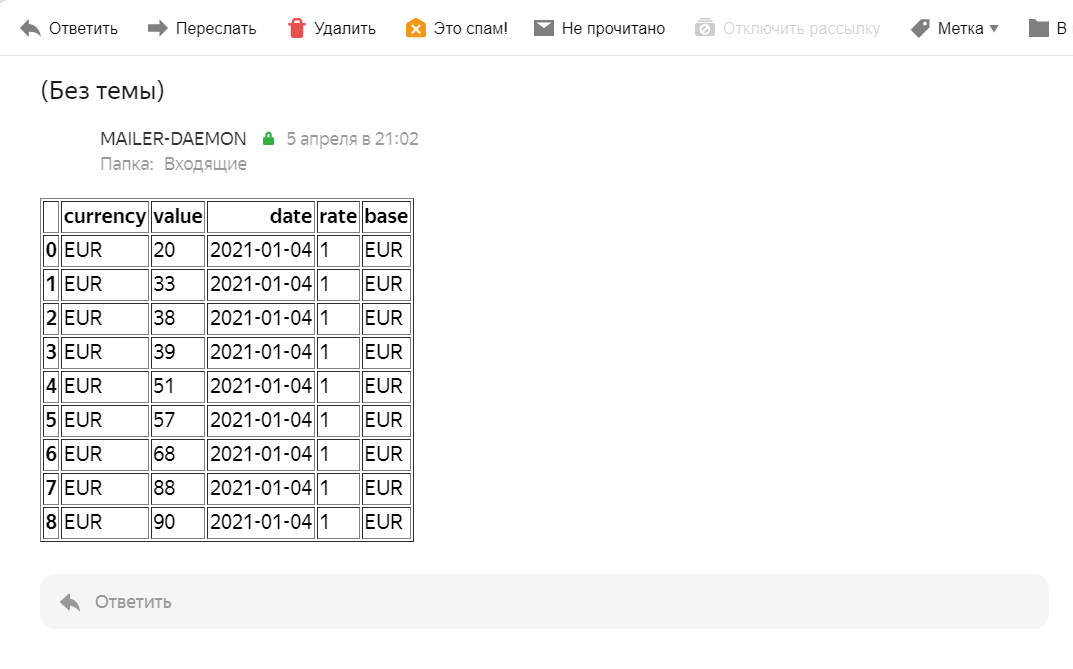

# База
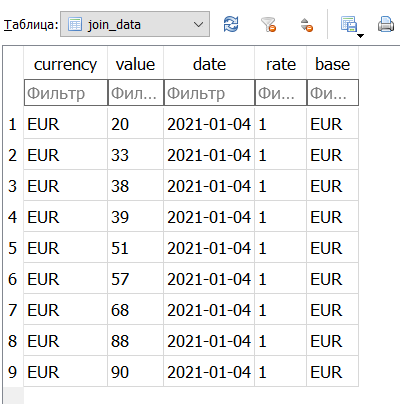